# Kiva.org: Extended EDA + Report

EDA guiding questions:
- In which countries are there more male borrowers? Groups of people?
- Investigate large sum loans. What is the typical use of such loans? In which countries do they originate? What is the gender structure of the borrowers?
- Investigate the relationship between country (region), the gender of the borrower and the amount borrowed. What conclusions are supported by the data?

### Importing modules and loading the data

In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_mpi = pd.read_csv("kiva_mpi_region_locations.csv")

In [3]:
df_kiva_loans.head(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [4]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True) > 0.005]
list_countries = list(countries.index)

In [5]:
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' \
                                     for elem in df_kiva_loans['borrower_genders'] ]

### In which countries are there more male borrowers?

In [6]:
male_borrower_dominance = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'female'])[-20:]

male_borrower_dominance = male_borrower_dominance[['male', 'female', 'group']]

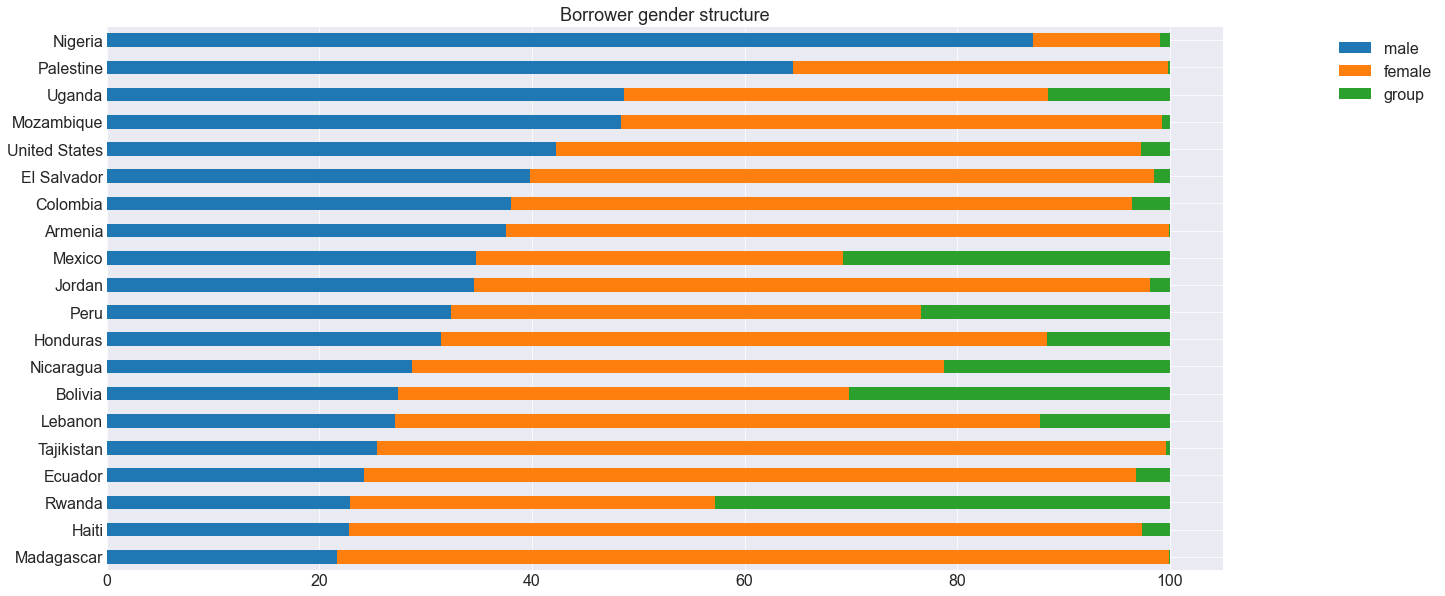

In [7]:
plot = male_borrower_dominance.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Borrower gender structure')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

It is noticeable that most of the borrowers are male in African countries like Nigeria, Uganda, and Mozambique. It can potentially be explained by the household role of women - they are mostly engaged in work about the house and the upbringing of children. It it interesting to see the United States in the list. Potential explanation - enhanced gender equality in the United States compared to other countries.

### In which countries do group borrowers dominate?

In [8]:
group_borrower_dominance = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group', 'female'])[-20:]

group_borrower_dominance = group_borrower_dominance[['group', 'female', 'male']]

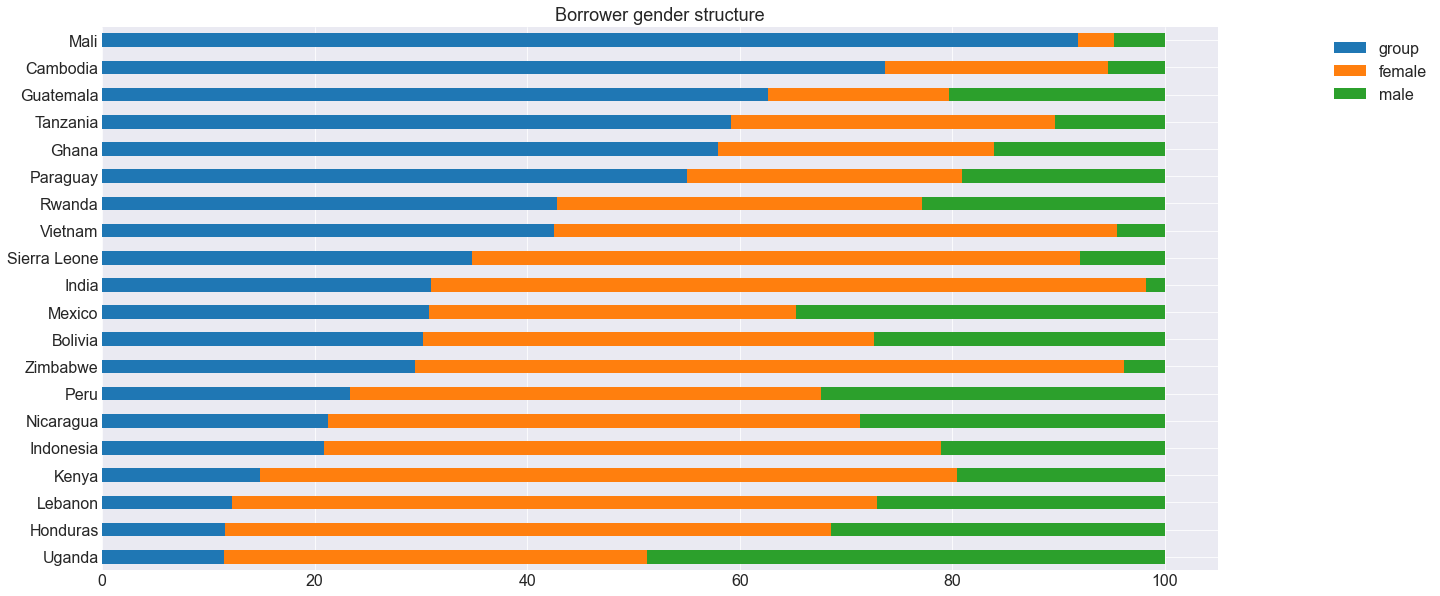

In [10]:
plot = group_borrower_dominance.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Borrower gender structure')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

Group borrowers mainly dominate in countries with lower median amount borrowed. It might be an illustration of people combining their efforts and helping each other due to inability to afford the loan individually.

### Investigating large sum loans (\$50000 and above)

In [11]:
large_loans = df_kiva_loans[df_kiva_loans["loan_amount"] >= 50000][["sector", "activity", "use", 
                                                                    "country", "borrower_genders", "loan_amount"]]

large_loans.head()

,sector,activity,use,country,borrower_genders,loan_amount
34196,Retail,Renewable Energy Products,to buy and sell Barefoot Power's Solar Lightin...,Peru,male,50000.0
43182,Retail,Renewable Energy Products,To buy and sell Barefoot Power's solar lightin...,Kenya,male,50000.0
53634,Retail,Renewable Energy Products,To buy and sell Barefoot Power solar lighting.,Uganda,female,50000.0
70499,Agriculture,Agriculture,create more than 300 jobs for women and farmer...,Haiti,female,100000.0
126839,Agriculture,Agriculture,to buy and plant resin producing pine trees. T...,Mexico,group,50000.0


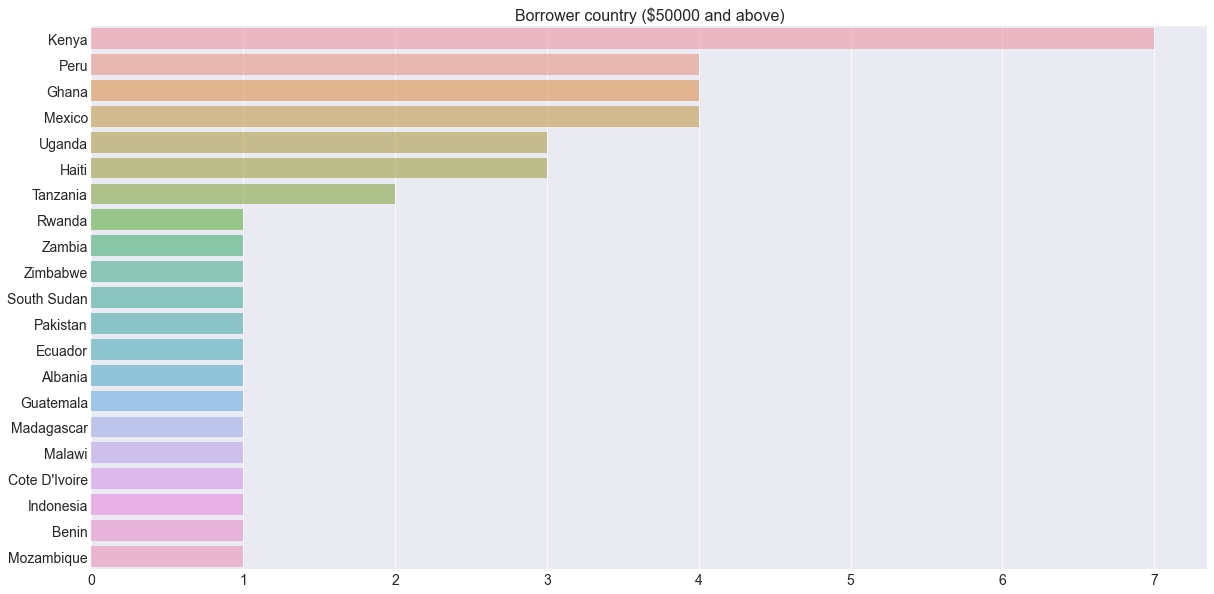

In [12]:
plt.figure(figsize=(20, 10))
plt.title("Borrower country ($50000 and above)", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(y=large_loans["country"].value_counts().index, 
            x=large_loans["country"].value_counts().values, alpha=0.6)
plt.show()

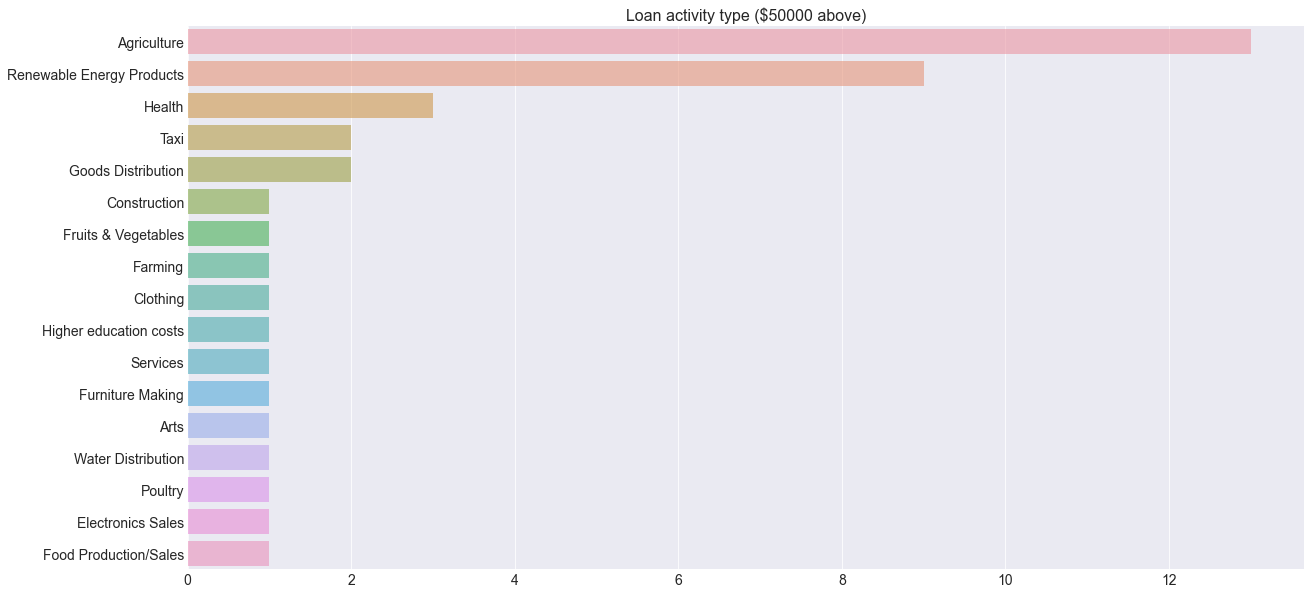

In [14]:
plt.figure(figsize=(20, 10))
plt.title("Loan activity type ($50000 above)", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(y=large_loans["activity"].value_counts().index, 
            x=large_loans["activity"].value_counts().values, alpha=0.6)
plt.show()

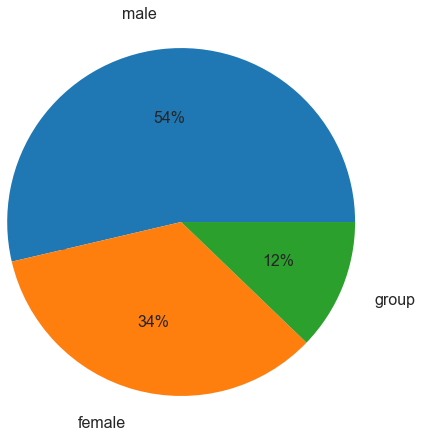

In [15]:
big_borrowers = large_loans['borrower_genders'].value_counts()

plot = big_borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

It is difficult to identify one clear-cut trend regarding countries where people borrowed large amounts of money. Nonetheless, there is a slight incline towards loans for agriculture and energy needs. One can assume that such loans are directed towards fundamental support of the agriculture and energy sectors respectively, and the loaners might rely on Kiva for massive industry reforms. Regarding the gender distribution, most of the borrowers are male. Hypothetically, it points to greater support that men get for big projects and the effect of gender inequality on the distribution of income between men and women.

### Relationship between borrower region, gender, and loan amount

In [16]:
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')

In [17]:
regions = df_kiva_loans['world_region'].value_counts()
regions_list = regions.index.to_list()

In [18]:
# observed deviation from the mean
dev = (df_kiva_loans['loan_amount'] - df_kiva_loans['loan_amount'].mean()).abs()
# standard deviation
std = df_kiva_loans['loan_amount'].std()
# filtering the original dataset
df_kiva_loans_trimmed = df_kiva_loans[~(dev > 3*std)]

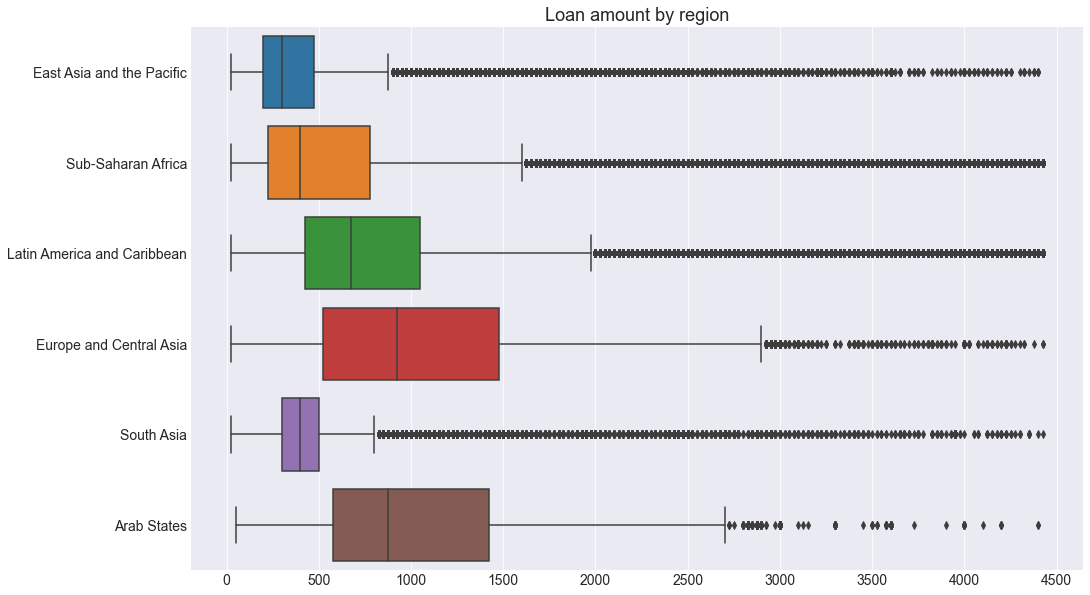

In [19]:
plt.figure(figsize=(16, 10))
plt.title("Loan amount by region", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount'] + 1), 500))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="world_region", order=regions_list, data=df_kiva_loans_trimmed)\
    .set(ylabel=None, xlabel=None)
plt.show()

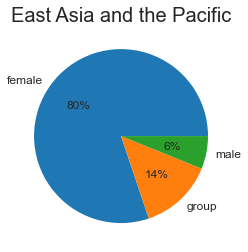

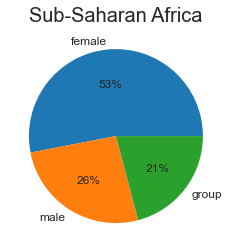

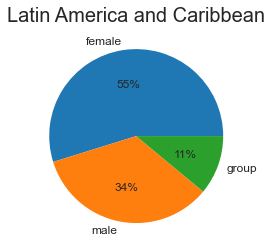

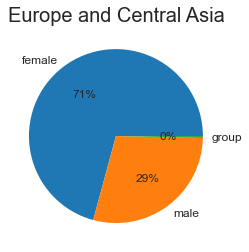

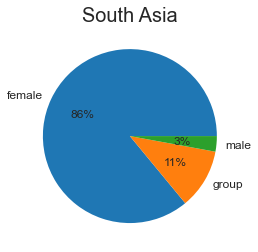

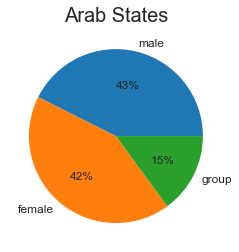

In [20]:
for i, region in enumerate(regions_list):
    plt.figure(i)
    tmp_df = df_kiva_loans_trimmed[df_kiva_loans_trimmed["world_region"] == regions_list[i]]["borrower_genders"]
    plt.title(region, fontsize=20)
    plt.axis("off")
    
    tmp_df.value_counts().plot.pie(fontsize=12, autopct='%1.0f%%', labeldistance=1.1, radius=1)

Loan amounts are typically larger in financially stable regions (such as Europe and Central Asia, Arab States). It is likely that in these countries money is borrowed to improve the existing infrastructure and for other similar purposes while other parts of the world require loans to satisfy basic survival needs. Regarding the gender distribution, most of the regions see more male borrowers. However, in the Arab States the male and female borrowers are approximately equal in their numbers. This indicates women's desire to move forward and develop despite traditional stereotypes.

## Additional exploratory questions
***

- The relationship between borrower gender and economy sector.
- The impact of the `lender_count` attribute on the loan amounts and time periods.
- The impact of the `MPI` attribute ("Multidimensional Poverty Index") in different countries on the loan amounts and return time periods.
- The loan amount, time period, and financing time trends by region.

### The relationship between gender and economy sector.

In [21]:
sectors = df_kiva_loans['sector'].value_counts()

In [22]:
loans_by_activity_sector = \
    df_kiva_loans[df_kiva_loans['sector'].isin(sectors[:9].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

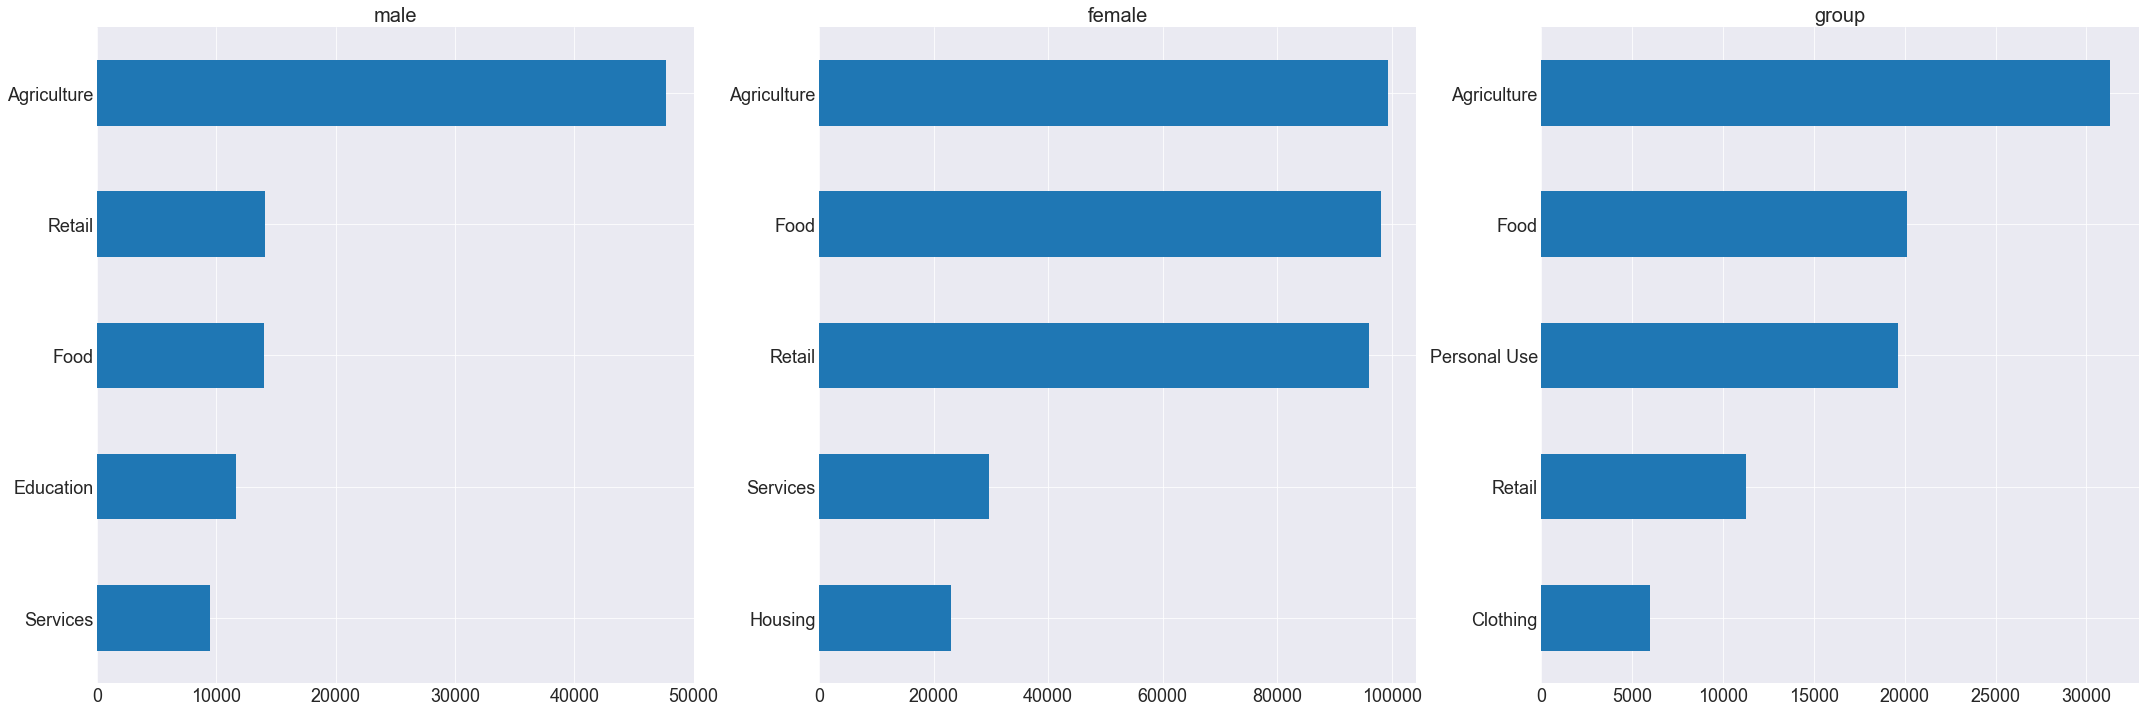

In [23]:
fig, axes = plt.subplots(1, 3, sharex=False, squeeze=False, figsize=(30, 10))

for ax, gender in zip(axes.ravel(), ["male", "female", "group"]):
    tmp_df = df_kiva_loans_trimmed[df_kiva_loans_trimmed["borrower_genders"] == gender]["sector"].value_counts()\
        [:5].sort_values(ascending=True)
    ax.set_title(gender, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(tmp_df, ax=ax, legend=None, fontsize=18)

Agriculture sector loans dominate across all three categories which illustrates the types of the economy of the borrower countries. Food and retail loans are also popular for all gender groups as they are known to be universally popular spending groups. It is interesting to see education appearing in the top-5 for men - completing secondary and high education for this gender group becomes more and more essential over time.

In [24]:
len(sectors.index)

15

In [25]:
for i in sectors.index:
    print(i)

Agriculture
Food
Retail
Services
Personal Use
Housing
Clothing
Education
Transportation
Arts
Health
Construction
Manufacturing
Entertainment
Wholesale


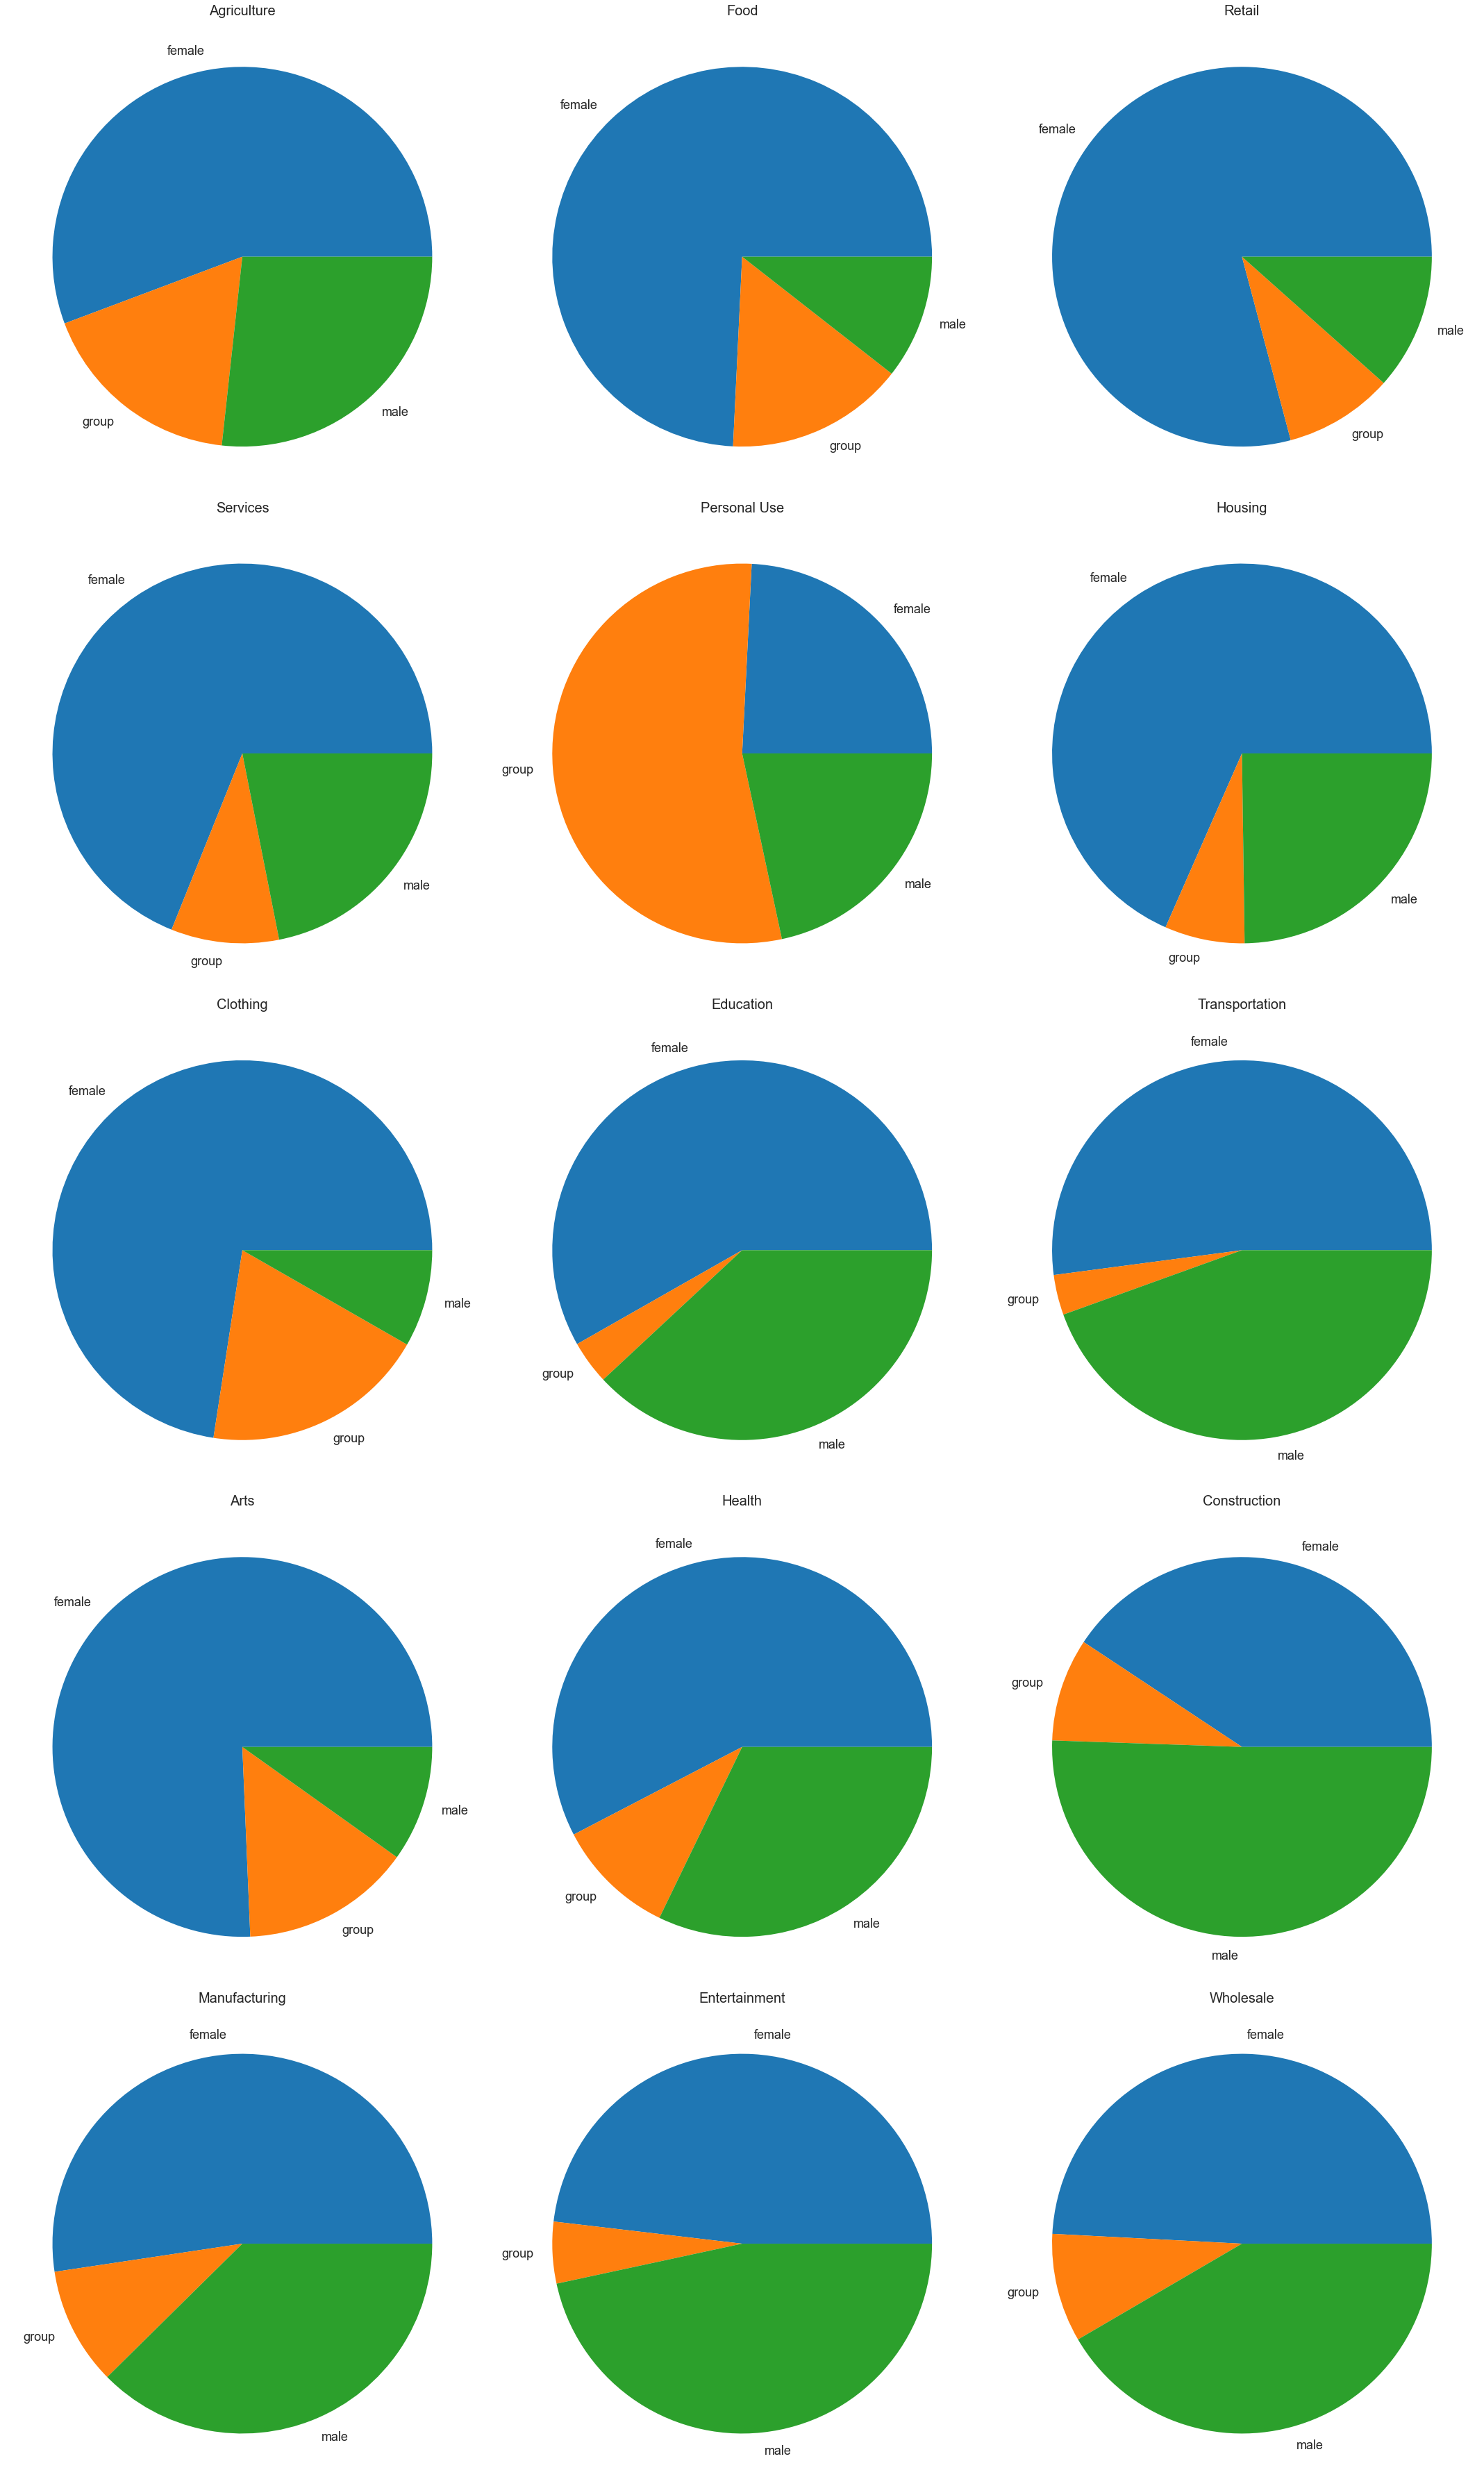

In [26]:
fig, axes = plt.subplots(5, 3, sharex=False, squeeze=False, figsize=(30, 50))

for ax, sector in zip(axes.ravel(), sectors.index):
    tmp_df = df_kiva_loans_trimmed[df_kiva_loans_trimmed["sector"] == sector]["borrower_genders"].value_counts()\
        .sort_index()
    ax.set_title(sector, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.pie(x=tmp_df, ax=ax, legend=None, fontsize=18)

Women dominate in their numbers in 12 out of 15 considered sectors. Male borrowers, in turn, request many loans for sectors such as transport, construction, and entertainment. Some of the sectors are considered traditionally male while others are more of a surprise finding. Most of the group loans were for personal use - once again, people group and combine their efforts to be able to repay loans for their most basic needs.

### The impact of MPI on loan amounts and repay periods

In [27]:
import warnings
warnings.filterwarnings("ignore")

# drop na (missing) values
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time'] - df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding'] - df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()

# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev > 3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

In [28]:
mpi_stats = df_loans_dates_trimmed.groupby(["MPI"]).agg({"loan_amount": "median", "term_in_months": "median"})

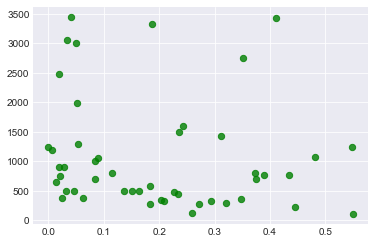

In [29]:
plt.scatter(mpi_stats.index, mpi_stats["loan_amount"], 40, 'g', 'o', alpha=0.8)
plt.show()

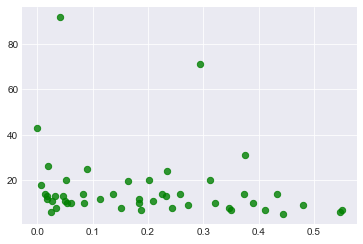

In [30]:
plt.scatter(mpi_stats.index, mpi_stats["term_in_months"], 40, 'g', 'o', alpha=0.8)
plt.show()

Other than several outliers, MPI does not have a clear relationship with loan amount or repay time period. It is an indication of Kiva's non-discriminating approach with people being eligible for receiving loans regardless of the country overall MPI.

### Loan amount, time period, and financing time trends by region

In [31]:
df_country_median = df_loans_dates_trimmed.groupby(['world_region', 'country'])\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

df_country_median = df_country_median[df_country_median.country.isin(list_countries)].sort_values(by='time_funding')
df_country_median['monthly_repayment'] = df_country_median['loan_amount'] / df_country_median['term_in_months']

In [32]:
region_stats = df_country_median.groupby("world_region")\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 
          'term_in_months' : 'median', "monthly_repayment": "median"})
region_stats["region"] = region_stats.index

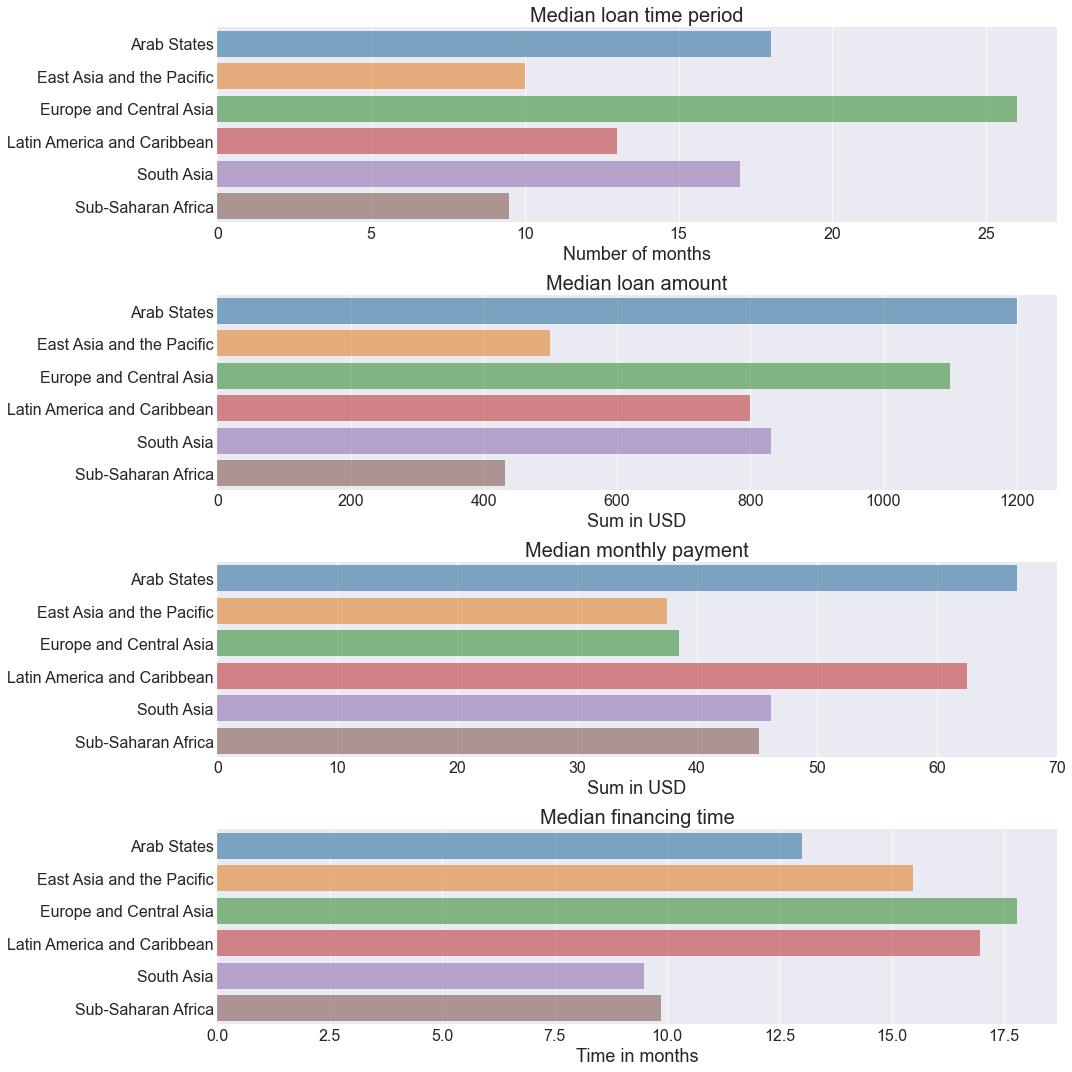

In [33]:
f,ax=plt.subplots(4, 1, figsize=(15,15))

sns.barplot(y='region', x='term_in_months', data=region_stats, alpha=0.6, ax=ax[0])
ax[0].set_title("Median loan time period", fontsize=20)
ax[0].set_xlabel('Number of months', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='region', x='loan_amount', data=region_stats, alpha=0.6, ax=ax[1])
ax[1].set_title("Median loan amount", fontsize=20)
ax[1].set_xlabel('Sum in USD', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

sns.barplot(y='region', x='monthly_repayment', data=region_stats, alpha=0.6, ax=ax[2])
ax[2].set_title("Median monthly payment", fontsize=20)
ax[2].set_xlabel('Sum in USD', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=16)

sns.barplot(y='region', x='time_funding', data=region_stats, alpha=0.6, ax=ax[3])
ax[3].set_title("Median financing time", fontsize=20)
ax[3].set_xlabel('Time in months', fontsize=18)
ax[3].set_ylabel(None)
ax[3].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

Arab States are leading in loan amounts and monthly payment which demonstrates the population's higher repaying ability. People in African regions and East Asia borrow less but also repay quicker. Financing periods are significantly shorter for applicants from South Asia and Africa which is a reason for Kiva to think about prioritizing urgent request for platform users. In general, the plots demonstrate the importance of Kiva focusing more on the regions in greater need - Africa, South and East Asia.